# MCT4052 Workshop 5g: Audio Files + PCA + ANN Regressor

*Author: Stefano Fasciani, stefano.fasciani@imv.uio.no, Department of Musicology, University of Oslo.*

The notebooks Workshop 5b to 5h integrates a stage of dimensionality reduction with different type of machine learning technique (classification, regression, clustering) on audio or MIDI data. The machine learning techniques included in this set of examples are those from previous workshops.

In [1]:
import numpy as np
import pandas as pd
import scipy
import librosa, librosa.display
import matplotlib.pyplot as plt
import matplotlib.style as ms
#ms.use("seaborn-v0_8")
import IPython.display as Ipd
import os
import sklearn

%matplotlib inline
%config IPCompleter.greedy=True

In [2]:
sr = 22050

def extract_features_targets(filename, sr):
    
    signal, dummy = librosa.load(filename, sr=sr, mono=True)
    
    features = librosa.feature.melspectrogram(y=signal, n_mels=15)
    features = features.flatten()
    
    targets = np.zeros((1,2))
    targets[0,0] = np.mean(librosa.feature.rms(y=signal))
    targets[0,1] = np.mean(librosa.feature.spectral_bandwidth(y=signal))
    
    return features, targets


filenames = os.listdir('./data/examples3')
num_of_features = extract_features_targets('./data/examples3/'+filenames[0], sr)[0].size
num_of_targets = extract_features_targets('./data/examples3/'+filenames[0], sr)[1].size
features = np.zeros((len(filenames),num_of_features)) 
targets = np.zeros((len(filenames),num_of_targets))

for i in range(len(filenames)):
    features[i,:], targets[i,:] = extract_features_targets('./data/examples3/'+filenames[i], sr)

print('Done!')

Done!


In [3]:
from sklearn.model_selection import train_test_split

#splitting the dataset in training and testing parts
feat_train, feat_test, tar_train, tar_test = train_test_split(features, targets, test_size=0.2, random_state=17)

In [4]:
from sklearn.preprocessing import StandardScaler

#learning the scaling transformation from the train data and applying it to both train and test set
#here we scale both features and target values

#creating scaling objects
feat_scaler = StandardScaler()
tar_scaler = StandardScaler()

#learning scaling from train set
feat_scaler.fit(feat_train)
tar_scaler.fit(tar_train)

#applying scaling to both train and test set, for features and target values
feat_train = feat_scaler.transform(feat_train)
feat_test = feat_scaler.transform(feat_test)

tar_train = tar_scaler.transform(tar_train)
tar_test = tar_scaler.transform(tar_test)

In [5]:
from sklearn.decomposition import PCA

#Creating an instance of a PCA object, which is an object capable of learning and applying PCA from/to data.
#We instruct the PCA to keep only N components
pca = PCA(n_components=20)

#This will learn PCA projection from train data
pca.fit(feat_train)

#Now we project the data
projected_features_train = pca.transform(feat_train)
projected_features_test = pca.transform(feat_test)

#this is only for scatter plot purposes
projected_features = pca.transform(feat_scaler.transform(features))

In [6]:
# keeping a lower number of dimensions
num_of_dim80 = np.min(np.where(np.cumsum(pca.explained_variance_ratio_)>0.80)) + 1

print(num_of_dim80)

# dimension before
print(projected_features_train.shape)
print(projected_features_test.shape)

# keeping only a number of components (columns, or features) carryinng 80% of total variance
projected_features_train = projected_features_train[:,0:num_of_dim80]
projected_features_test = projected_features_test[:,0:num_of_dim80]


# dimension after
print(projected_features_train.shape)
print(projected_features_test.shape)

12
(72, 20)
(18, 20)
(72, 12)
(18, 12)


In [7]:
#Import the classifier
from sklearn.neural_network import MLPRegressor

##Creating an instance of a MLP regressor
#and setting it some option (max mum epoch, verbose on, activation of neurons)
mlp = MLPRegressor(hidden_layer_sizes=(15,10,5), max_iter=500000, activation='tanh', verbose=False)

#train the model
mlp.fit(projected_features_train, tar_train)

#applying the the model on the test data (features)
tar_pred = mlp.predict(projected_features_test)

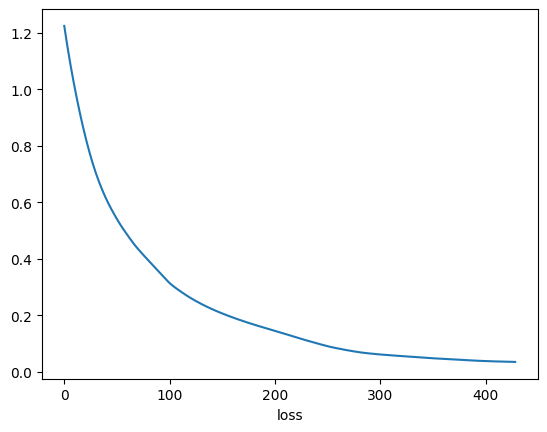

Mean squared error: 0.0605
Mean absolute error: 0.1820
Median absolute error: 0.1273
Coefficient of determination (R2 score): 0.9383
Explained variance score: 0.9437
R2 score on individual targets [0.95498759 0.92156118]


In [8]:
#plotting the loss curve over training iteration 
plt.plot(mlp.loss_curve_)
plt.xlabel('iteration')
plt.xlabel('loss')
plt.show()

#computing a set of performance metrics

#mean squared error (lower the better)
print('Mean squared error: %.4f'% sklearn.metrics.mean_squared_error(tar_test, tar_pred))

#mean absolute error (lower the better)
print('Mean absolute error: %.4f'% sklearn.metrics.mean_absolute_error(tar_test, tar_pred))

#median absolute error (lower the better)
print('Median absolute error: %.4f'% sklearn.metrics.median_absolute_error(tar_test, tar_pred))

#coefficient of determination (r2 score): 1 is perfect prediction (it can get arbitrary negative)
print('Coefficient of determination (R2 score): %.4f'% sklearn.metrics.r2_score(tar_test, tar_pred))

#explained variance score: 1 is perfect prediction (it can get arbitrary worse)
print('Explained variance score: %.4f'% sklearn.metrics.explained_variance_score(tar_test, tar_pred))

#this is is a better represenation of the r2 score when working with multiple outputs
#as it provides a value for each target value
print('R2 score on individual targets',sklearn.metrics.r2_score(tar_test, tar_pred, multioutput='raw_values') )

In [9]:
# converting the predicted test target values back to their original range using the scaler inverse transformation

tar_pred_non_scaled = tar_scaler.inverse_transform(tar_pred)
tar_pred_non_scaled

array([[2.19535449e-01, 8.75699961e+02],
       [1.03409483e-02, 1.79649130e+02],
       [1.45078899e-01, 4.41485155e+02],
       [1.04513227e-01, 1.31096123e+03],
       [1.60907495e-01, 5.59891776e+02],
       [2.16513311e-02, 2.75188655e+02],
       [1.07581034e-01, 1.23346615e+03],
       [2.19296842e-01, 9.61989370e+02],
       [2.70194521e-02, 5.36313014e+02],
       [1.60558887e-01, 1.08075163e+03],
       [2.25069097e-02, 3.12305245e+02],
       [1.07550814e-01, 1.23277475e+03],
       [1.19986177e-01, 1.11386580e+03],
       [9.65488042e-02, 3.43316136e+02],
       [8.95450125e-02, 2.01911401e+02],
       [1.08009343e-01, 8.24341871e+02],
       [2.28921102e-01, 2.48591258e+02],
       [9.50024958e-02, 2.69371293e+02]])